# Tutorial 5: Visualizing Synthetic Grids with Geo-Referencing
This tutorial focuses on visualizing the synthetic networks you generated in previous steps.

We will take the raw .csv sample data and the pandapower network topology and combine them with geographic data to create maps of:

1) Phase Allocation & Topology: Seeing the phase balancing across the grid.

2) Active power across all phases

3) Reliability Metrics: Visualizing Failure Frequency (CAIFI) and Duration (CAIDI) heatmaps.

4) Line Impedance: Inspecting the Resistance (R) and Reactance (X) of the lines.


**Important: seaborn is required as an additional package for this tutorial**

In [1]:
import os
import json
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import our custom Bayesian model classes

from bayesgrid import BayesianPowerModel, BayesianFrequencyModel, BayesianDurationModel, BayesianImpedanceModel

from bayesgrid import create_osm_pandapower_network,save_bus_metric_samples,save_power_phase_samples,save_impedance_samples




print("Libraries imported successfully.")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Helper functions for saving are defined.
Libraries imported successfully.


# Step 1: Defining the Network and Data Source

In this step, we define the inputs required for visualization. 

**Important Prerequisites:**
This tutorial assumes you have already completed **Tutorial 2 (Synthetic grids anywhere with OpenStreetMaps)**. 
Specifically, you must have:
1.  Generated a synthetic grid.
2.  Saved the network topology (the `pandapower` network).
3.  Saved the synthetic data samples (CSVs) in an output folder.

We will now load this pre-generated network and define the folder where our Bayesian models stored their results.

In [2]:

SYNTHETIC_DATA_FOLDER = 'new_osm_synthetic_net' # Folder to save our results

# A point in Santo Amaro, São Paulo
query_point = (-23.649, -46.702)

# net = os.path.join(SYNTHETIC_DATA_FOLDER,'pandapower_network.p')

# We can specify a different line type for this network
net_point, tree_graph_point = create_osm_pandapower_network(
    query_point, 
    query_type='point', 
    dist=1500, # 1500-meter radius
    line_std_type="48-AL1/8-ST1A 20.0" # Example of a different standard
)
print(net_point)
net = net_point
tree_graph = tree_graph_point


#net = pp.from_pickle(os.path.join(SYNTHETIC_DATA_FOLDER,'pandapower_network.p'))

# Keep these for the next steps
source_bus = net.ext_grid.bus.iloc[0] 
graph_from_net = pn.create_nxgraph(net)

Fetching graph for query '(-23.649, -46.702)' (type: point)...
No substation_point provided. Finding graph center...
Using graph center: (-23.6488, -46.7023)
Substation node selected: 2380734697
Radializing graph from source node 2380734697...
Original graph: 951 nodes, 1422 edges
Radial tree: 951 nodes, 950 edges
Converting NetworkX graph to pandapower network...
Created 951 buses.
Created 950 lines.
Added External Grid at bus 0 (Node 2380734697).

--- OSM pandapower network creation complete! ---
This pandapower network includes the following parameter tables:
   - bus (951 elements)
   - ext_grid (1 element)
   - line (950 elements)


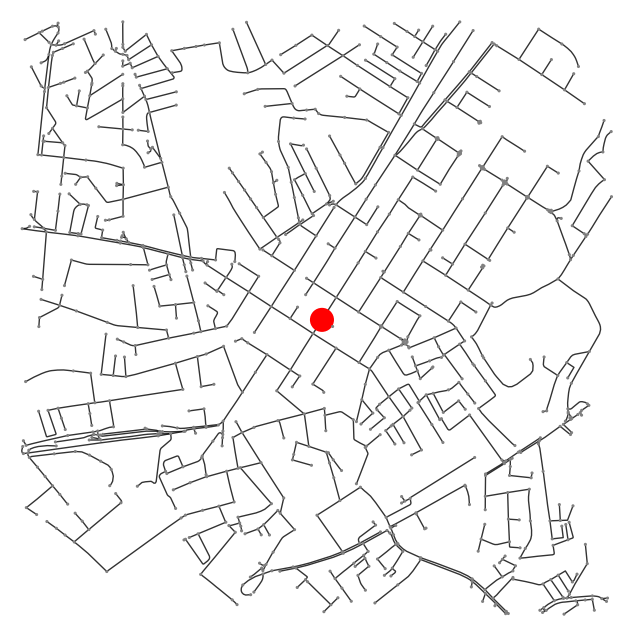

In [3]:




substation_node = net.bus.name.iloc[source_bus] # Get original osmnx node ID

# --- 1. Prepare Node Colors and Sizes ---
node_colors = []
node_sizes = []
for node in tree_graph.nodes():
    if str(node) == substation_node:
        node_colors.append('red')   # Highlight color for the substation
        node_sizes.append(300)      # Make it larger
    else:
        node_colors.append('gray')  # Color for other nodes
        node_sizes.append(5)        # Make other nodes small

# --- 2. Create and Customize the Plot ---
fig, ax = ox.plot_graph(
    tree_graph,
    node_color=node_colors,
    node_size=node_sizes,
    node_zorder=2,
    edge_color='black',
    edge_linewidth=1.0,
    edge_alpha=0.8,
    bgcolor='white',
    show=False,
    close=False,
)


In [ ]:


# Define Data Paths
# Point to the folder where you saved your samples

print(f"Loading synthetic samples from: {SYNTHETIC_DATA_FOLDER}")
df_power = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'bus_power_and_phase_SAMPLES.csv'))
df_freq = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'bus_frequency_SAMPLES.csv'))
df_dur = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'bus_duration_SAMPLES.csv'))
df_imp = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'line_impedance_SAMPLES.csv'))

print("Data loaded successfully.")

Loading synthetic samples from: new_osm_synthetic_net
Data loaded successfully.


In [5]:
def get_bus_geo_dict(net):
    """
    Extracts geographic coordinates from a pandapower network.
    Handles both simple 'x/y' columns and JSON 'geo' columns.
    
    Returns:
        dict: {bus_index: [x, y]}
    """
    bus_geo = {}
    
    if 'geo' in net.bus.columns:
        for idx, row in net.bus.iterrows():
            geo_str = row['geo']
            if pd.isna(geo_str):
                continue
            try:
                # Parse the JSON string
                # e.g. '{"coordinates":[-51.23, -21.04], "type":"Point"}'
                geo_data = json.loads(geo_str)
                coords = geo_data['coordinates']
                # GeoJSON is usually [lon, lat], i.e., [x, y]
                bus_geo[idx] = [coords[0], coords[1]]
            except (json.JSONDecodeError, KeyError, TypeError):
                pass
                
    # Case 3: Fallback to generic layout if no geo data exists
    if not bus_geo:
        print("Warning: No geo data found. Using generic spring layout.")
        graph = pp.topology.create_nxgraph(net)
        bus_geo = nx.spring_layout(graph)
        
    return bus_geo

# Create the geo-dictionary and graph
bus_geo_data = get_bus_geo_dict(net)
graph_from_net = pp.topology.create_nxgraph(net)
source_bus = net.ext_grid.bus.iloc[0]

print(f"Extracted coordinates for {len(bus_geo_data)} buses.")
print(f"Example coord for bus {source_bus}: {bus_geo_data[source_bus]}")

Extracted coordinates for 951 buses.
Example coord for bus 0: [-46.701839, -23.649094]


## Step 3: Select a Sample to Visualize

Since our CSVs contain many stochastic samples (e.g., 100 variations), we must select **one** specific sample ID to visualize. This allows you to see how a single, consistent realization of the network looks.


In [30]:
# Choose which sample to visualize (0 to N_SAMPLES - 1)
SAMPLE_ID = 53

print(f"Filtering data for Sample ID: {SAMPLE_ID}")

# Filter DataFrames
sample_power = df_power[df_power['sample_id'] == SAMPLE_ID].set_index('bus_id')
sample_freq = df_freq[df_freq['sample_id'] == SAMPLE_ID].set_index('bus_id')
sample_dur = df_dur[df_dur['sample_id'] == SAMPLE_ID].set_index('bus_id')
sample_imp = df_imp[df_imp['sample_id'] == SAMPLE_ID].set_index('line_id')

print("Data filtered.")

Filtering data for Sample ID: 53
Data filtered.


## Visualization 1: Phase Allocation

This plot colors each node based on its allocated phase (A, B, C, AB, etc.). It helps visualize phase balance and branching.


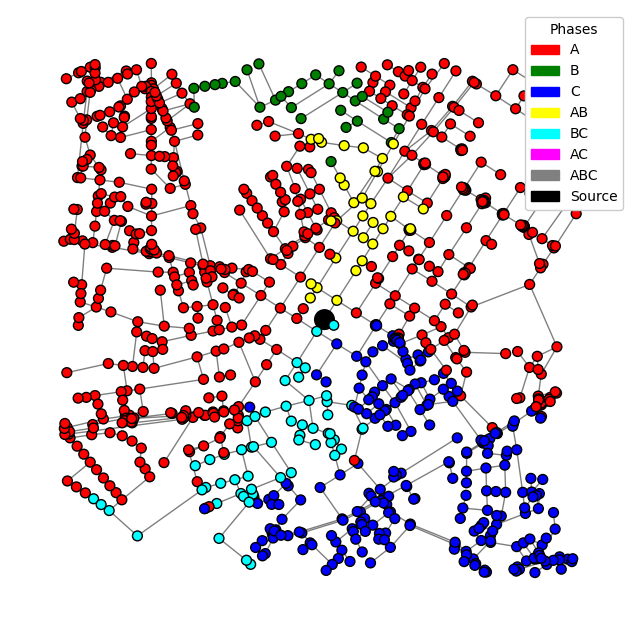

In [31]:

# --- 1. Map Phases to Colors ---
# Define standard colors for phases
phase_colors = {
    'A': 'red', 'B': 'green', 'C': 'blue',
    'AB': 'yellow', 'BC': 'cyan', 'AC': 'magenta', # Note: using AC for consistency
    'ABC': 'white', 'nan': 'black'
}

node_colors = []
for node in graph_from_net.nodes:
    if node == source_bus:
        node_colors.append('black') # Source is black
    else:
        try:
            phase = str(sample_power.loc[node, 'phase'])
            # Handle potential 'CA' vs 'AC' naming differences
            if phase == 'CA': phase = 'AC'
            node_colors.append(phase_colors.get(phase, 'black'))
        except KeyError:
            node_colors.append('black')

# --- 2. Plotting ---
plt.figure(figsize=(8, 8))

# Draw edges
nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, edge_color='black', alpha=0.5)

# Draw nodes
nx.draw_networkx_nodes(
    graph_from_net, pos=bus_geo_data,
    node_size=[200 if n==source_bus else 50 for n in graph_from_net.nodes],
    node_color=node_colors,
    edgecolors='black' # Add border to nodes
)

# Create Custom Legend
handles = [
    Circle(0, color='red', label='A'),
    Circle(0, color='green', label='B'),
    Circle(0, color='blue', label='C'),
    Circle(0, color='yellow', label='AB'),
    Circle(0, color='cyan', label='BC'),
    Circle(0, color='magenta', label='AC'),
    Circle(0, color='gray', label='ABC'),
    Circle(0, color='black', label='Source')
]
plt.legend(handles=handles, loc='best', title="Phases",ncols=1,framealpha=1)
#plt.title(f"Network Phase Allocation (Sample {SAMPLE_ID})")
plt.axis('off')
plt.show()

## Visualization 2: Power Demand per Phase
This visualization plots the Active Power (kW) demand for each phase side-by-side.

Crucial Detail: We calculate a global minimum and maximum power across all three phases. This ensures that a specific color (e.g., bright orange) represents the same amount of kW in all three plots, allowing you to visually compare the load balance between Phase A, B, and C.

Power Range: 0.00 kW to 3351.86 kW


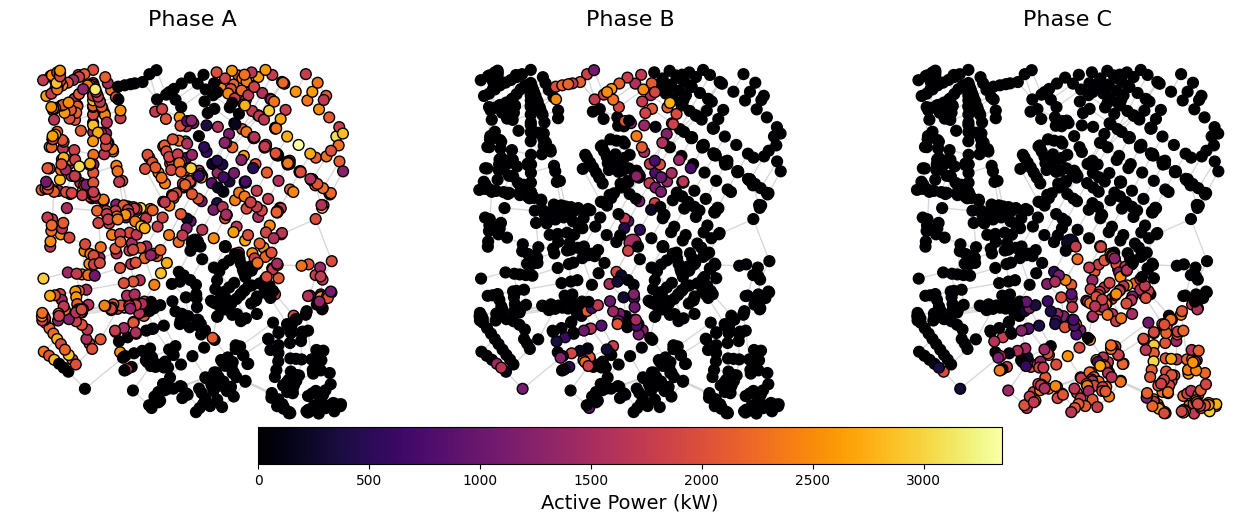

In [42]:
# --- 1. Prepare Data ---
# Extract power values for each phase, aligned with graph nodes
p_a_values = [sample_power.loc[n, 'P_A'] if n in sample_power.index else 0 
              for n in graph_from_net.nodes]
p_b_values = [sample_power.loc[n, 'P_B'] if n in sample_power.index else 0 
              for n in graph_from_net.nodes]
p_c_values = [sample_power.loc[n, 'P_C'] if n in sample_power.index else 0 
              for n in graph_from_net.nodes]

# --- 2. Calculate Shared Limits ---
# We need a single min/max for all 3 plots to make colors comparable
all_p_values = p_a_values + p_b_values + p_c_values
p_min = min(all_p_values)
p_max = max(all_p_values)

print(f"Power Range: {p_min:.2f} kW to {p_max:.2f} kW")

# --- 3. Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Helper list for looping
phases_data = [
    ('Phase A', p_a_values, axes[0]),
    ('Phase B', p_b_values, axes[1]),
    ('Phase C', p_c_values, axes[2])
]

for phase_name, p_values, ax in phases_data:
    # Draw faint edges for context
    nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax, 
                           edge_color='gray', alpha=0.3)
    
    # Draw nodes colored by power
    nodes = nx.draw_networkx_nodes(
        graph_from_net, pos=bus_geo_data, ax=ax,
        node_size=[150 if n==source_bus else 60 for n in graph_from_net.nodes],
        node_color=p_values,
        cmap=plt.cm.inferno, # 'inferno' is great for intensity (black->red->yellow)
        vmin=p_min, vmax=p_max, # <--- Shared scale
        edgecolors='black'
    )
    ax.set_title(f"{phase_name}", fontsize=16)
    ax.axis('off')

# --- 4. Add Shared Colorbar ---
# Create a dummy mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin=p_min, vmax=p_max))
sm.set_array([])

# Place colorbar at the bottom
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.6, location='bottom', pad=-0.05)
cbar.set_label('Active Power (kW)', fontsize=14)

plt.show()

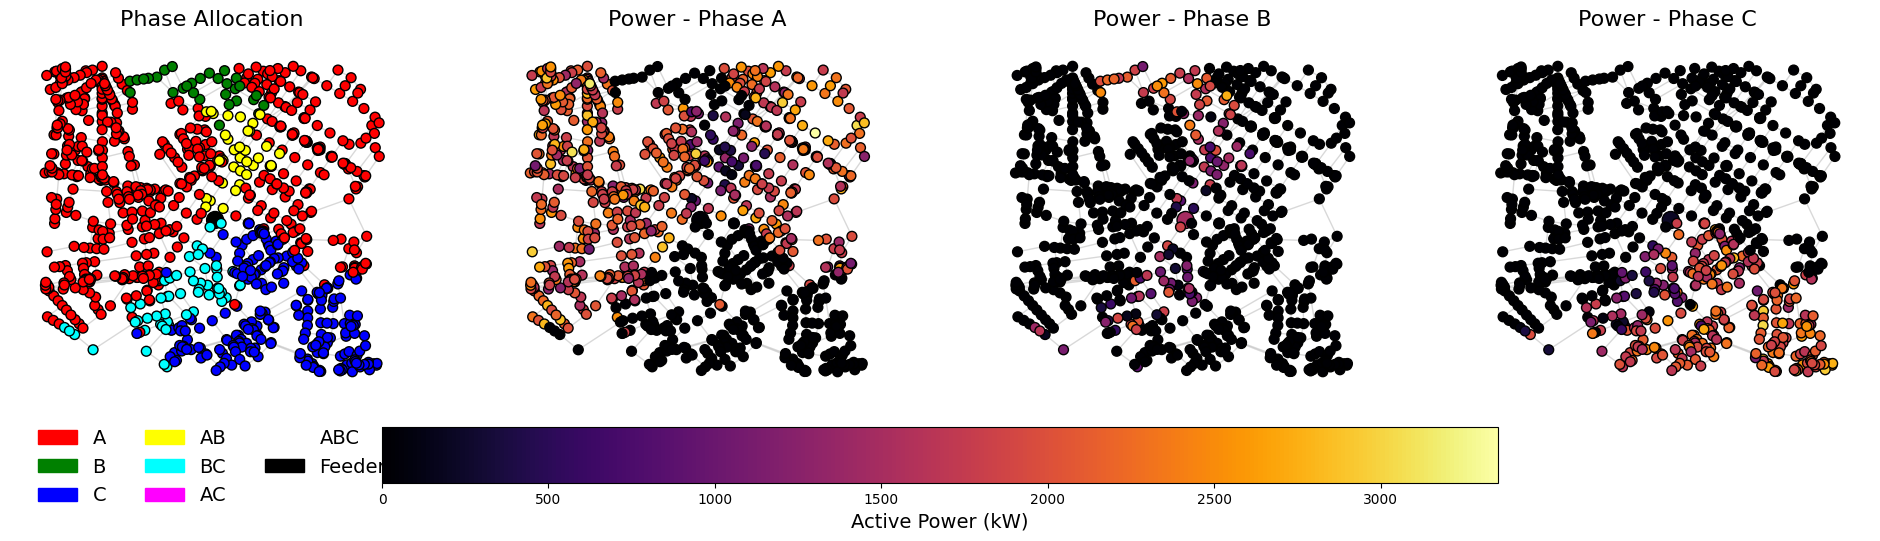

In [44]:


# Prepare Power Arrays (for columns 2-4)
p_a_values = [sample_power.loc[n, 'P_A'] if n in sample_power.index else 0 for n in graph_from_net.nodes]
p_b_values = [sample_power.loc[n, 'P_B'] if n in sample_power.index else 0 for n in graph_from_net.nodes]
p_c_values = [sample_power.loc[n, 'P_C'] if n in sample_power.index else 0 for n in graph_from_net.nodes]

# Calculate shared limits for power plots
all_p_values = p_a_values + p_b_values + p_c_values
p_min = min(all_p_values)
p_max = max(all_p_values)

# --- 2. Prepare Colors for Phases (Column 1) ---
# UPDATED color mapping
phase_colors = {
    'A': 'red', 'B': 'green', 'C': 'blue',
    'AB': 'yellow', 'BC': 'cyan', 'AC': 'magenta', # Note: using AC for consistency
    'ABC': 'white', 'nan': 'black'
}

node_colors_phase = []
for node in graph_from_net.nodes:
    if node == source_bus:
        node_colors_phase.append('black') # Source is black
    else:
        try:
            phase = str(sample_power.loc[node, 'phase'])
            if phase == 'CA': phase = 'AC'
            node_colors_phase.append(phase_colors.get(phase, 'black'))
        except KeyError:
            node_colors_phase.append('black')

# --- 3. Setup Plot ---
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Common drawing settings
edge_color = 'gray'
edge_alpha = 0.3
node_size_source = 150
node_size_regular = 50

# ====================================================================
# --- Plot 1: Phase Allocation ---
# ====================================================================
ax = axes[0]
nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax, edge_color=edge_color, alpha=edge_alpha)
nx.draw_networkx_nodes(
    graph_from_net, pos=bus_geo_data, ax=ax,
    node_size=[node_size_source if n==source_bus else node_size_regular for n in graph_from_net.nodes],
    node_color=node_colors_phase,
    edgecolors='black'
)
ax.set_title("Phase Allocation", fontsize=16)
ax.axis('off')

# --- Custom Legend Below Plot 1 ---
handles = [Circle(0, color=c, label=l) for l, c in phase_colors.items() if l != 'nan']
# Add Source manually if desired, or assume 'nan' covers it
handles.append(Circle(0, color='black', label='Feeder'))

# bbox_to_anchor moves the legend outside the plot. (0.5, -0.05) is centered below.
ax.legend(
    handles=handles, 
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.02), 
    ncol=3, 
    fontsize=14, 
    frameon=False,
)

# ====================================================================
# --- Plots 2, 3, 4: Power Demand ---
# ====================================================================
power_plots = [
    ('Power - Phase A', p_a_values, axes[1]),
    ('Power - Phase B', p_b_values, axes[2]),
    ('Power - Phase C', p_c_values, axes[3])
]

for title, p_vals, ax in power_plots:
    nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax, edge_color=edge_color, alpha=edge_alpha)
    nx.draw_networkx_nodes(
        graph_from_net, pos=bus_geo_data, ax=ax,
        node_size=[node_size_source if n==source_bus else node_size_regular for n in graph_from_net.nodes],
        node_color=p_vals,
        cmap=plt.cm.inferno,
        vmin=p_min, vmax=p_max,
        edgecolors='black'
    )
    ax.set_title(title, fontsize=16)
    ax.axis('off')

# ====================================================================
# --- Shared Colorbar for Power (Below Plots 2-4) ---
# ====================================================================
sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin=p_min, vmax=p_max))
sm.set_array([])

# # Add colorbar associated with the last 3 axes
cbar = fig.colorbar(sm, ax=axes, shrink=0.6, location='bottom', pad=0.05)
cbar.set_label('Active Power (kW)', fontsize=14)

plt.show()

## Visualization 3: Reliability Heatmaps (CAIFI & CAIDI)

This section generates two heatmaps: one for Failure Frequency (CAIFI) and one for Failure Duration (CAIDI).


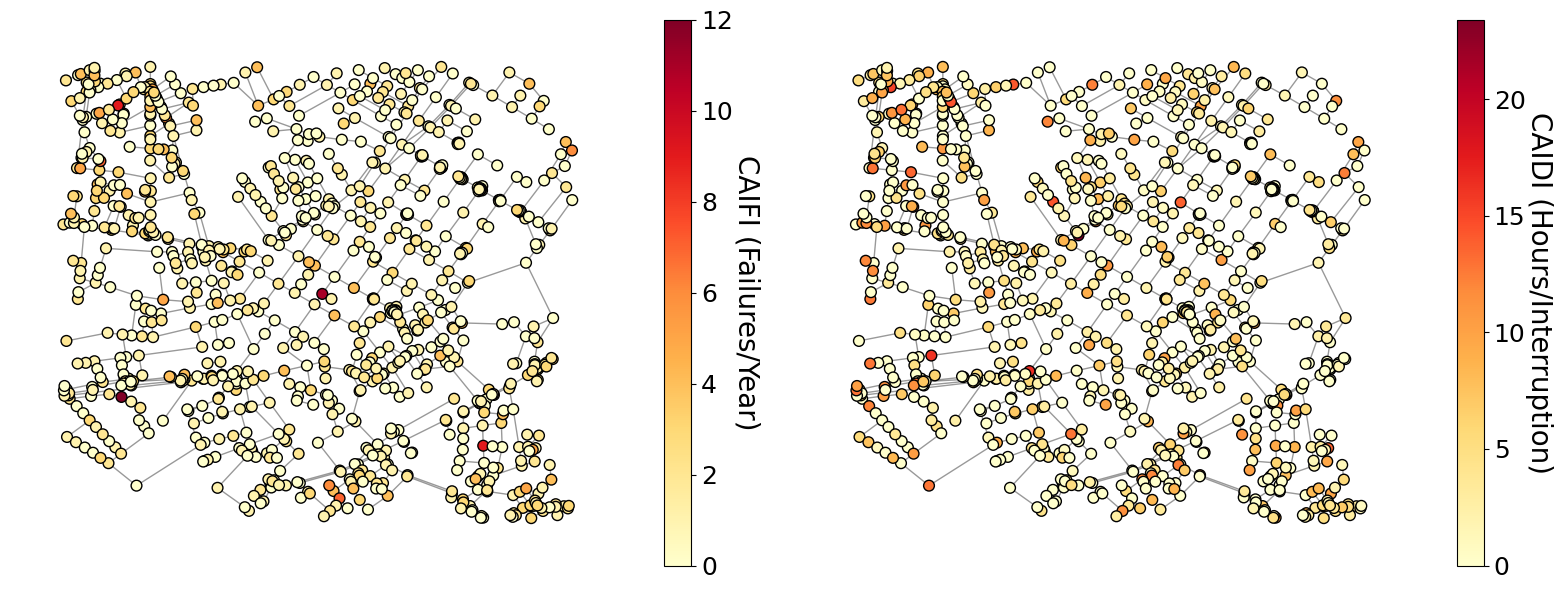

In [58]:
# --- Prepare Data for Plotting ---
# Map the values to the graph nodes (ensuring order matches graph.nodes)
freq_values = [sample_freq.loc[n, 'CAIFI_FIC'] if n in sample_freq.index else 0 
               for n in graph_from_net.nodes]

dur_values = [sample_dur.loc[n, 'CAIDI_DIC'] if n in sample_dur.index else 0 
              for n in graph_from_net.nodes]

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Frequency (CAIFI)
ax1 = axes[0]
nodes1 = nx.draw_networkx_nodes(
    graph_from_net, pos=bus_geo_data, ax=ax1,
    node_size=60, node_color=freq_values,
    cmap=plt.cm.YlOrRd, edgecolors='black'
)
nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax1, edge_color='black', alpha=0.4)
cbar1 = plt.colorbar(nodes1, ax=ax1)
cbar1.set_label('CAIFI (Failures/Year)', rotation=270, labelpad=20, fontsize=20)
cbar1.ax.tick_params(labelsize=18) # Adjust labelsize as desired
#ax1.set_title("Predicted Failure Frequency (CAIFI)")
ax1.axis('off')

# Plot 2: Duration (CAIDI)
ax2 = axes[1]
nodes2 = nx.draw_networkx_nodes(
    graph_from_net, pos=bus_geo_data, ax=ax2,
    node_size=60, node_color=dur_values,
    cmap=plt.cm.YlOrRd, edgecolors='black'
)
nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax2, edge_color='black', alpha=0.4)
cbar2 = plt.colorbar(nodes2, ax=ax2)
cbar2.set_label('CAIDI (Hours/Interruption)', rotation=270, labelpad=20, fontsize=20)
cbar2.ax.tick_params(labelsize=18) # Adjust labelsize as desired
#ax2.set_title("Predicted Failure Duration (CAIDI)")
ax2.axis('off')

plt.tight_layout()
plt.show()

## Visualization 4: Line Impedance (R & X)

Here we visualize the electrical properties of the lines. Since 3-phase lines are physically thicker/different than 1-phase lines, we will scale the **edge width** based on the number of phases.

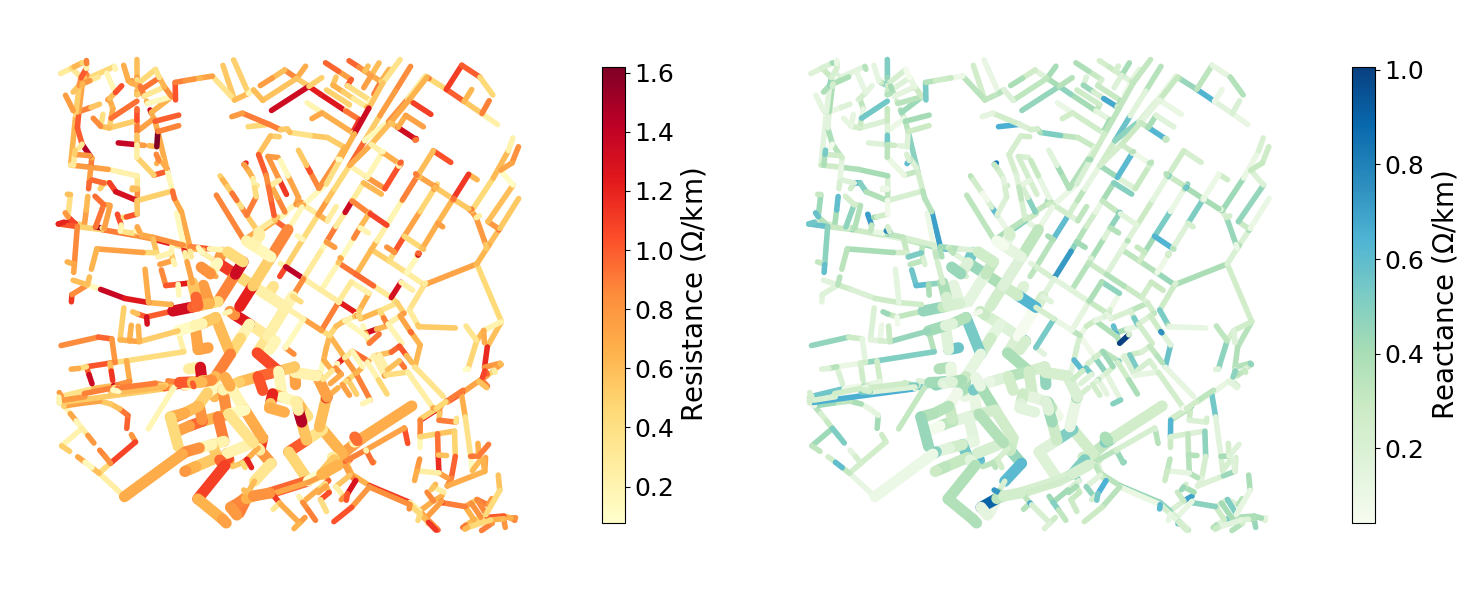

In [80]:
# --- 1. Prepare Edge Widths (Based on Phases) ---
# Helper to count phases
def get_phase_count(phase_str):
    if pd.isna(phase_str): return 1
    return len(str(phase_str).replace('ABC', '3')) 

phase_count_to_width = {1: 4.0, 2: 8, 3: 12} # Adjusted for borders

# Calculate width for each edge in the graph
edge_widths = []
for u, v, _ in graph_from_net.edges:
    # Find the phase of the *downstream* node (approximate line phase)
    # We use 'to_bus' phase as a proxy for the line
    try:
        phase_str = sample_power.loc[v, 'phase']
        phase_count = get_phase_count(phase_str)
        width = phase_count_to_width[phase_count]
    except KeyError:
        width = 1.0
    edge_widths.append(width)

# --- 2. Prepare Edge Colors (R and X values) ---
# Map line indices to graph edges
# Note: pandapower graph edges are usually (from_bus, to_bus, key) or just (u, v)
# We iterate through net.line to match R/X values to specific edges
r_values = []
x_values = []

# Create a map of (u, v) -> index to ensure order
edge_to_idx = {edge[0:2]: i for i, edge in enumerate(graph_from_net.edges)}
r_ordered = [0.0] * len(graph_from_net.edges)
x_ordered = [0.0] * len(graph_from_net.edges)

for idx, row in net.line.iterrows():
    u, v = row['from_bus'], row['to_bus']
    
    # Check if edge exists in graph (it should)
    if graph_from_net.has_edge(u, v):
        # Get the integer index of this edge in the graph list
        # Note: graph edges might be (u, v) or (v, u) since it's undirected
        edge_key = (u, v) if (u, v) in edge_to_idx else (v, u)
        
        if edge_key in edge_to_idx:
            list_idx = edge_to_idx[edge_key]
            
            # Get R/X from sample
            try:
                r_ordered[list_idx] = sample_imp.loc[idx, 'R1_ohm_per_km']
                x_ordered[list_idx] = sample_imp.loc[idx, 'X1_ohm_per_km']
            except KeyError:
                pass

# --- 3. Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot R1
ax1 = axes[0]
nx.draw_networkx_nodes(graph_from_net, pos=bus_geo_data, ax=ax1, node_size=0, node_color='black')
edges1 = nx.draw_networkx_edges(
    graph_from_net, pos=bus_geo_data, ax=ax1,
    edge_color=r_ordered, width=edge_widths,
    edge_cmap=plt.cm.YlOrRd
)
cbar1 = plt.colorbar(edges1, ax=ax1, shrink=0.8)
cbar1.set_label(r'Resistance ($\Omega$/km)', fontsize=20)
cbar1.ax.tick_params(labelsize=18) # Adjust labelsize as desired
#ax1.set_title("Line Resistance (R1)")
ax1.axis('off')

# Plot X1
ax2 = axes[1]
nx.draw_networkx_nodes(graph_from_net, pos=bus_geo_data, ax=ax2, node_size=0, node_color='black')
edges2 = nx.draw_networkx_edges(
    graph_from_net, pos=bus_geo_data, ax=ax2,
    edge_color=x_ordered, width=edge_widths,
    edge_cmap=plt.cm.GnBu
)
cbar2 = plt.colorbar(edges2, ax=ax2, shrink=0.8)
cbar2.set_label(r'Reactance ($\Omega$/km)', fontsize=20)
cbar2.ax.tick_params(labelsize=18) # Adjust labelsize as desired
#ax2.set_title("Line Reactance (X1)")
ax2.axis('off')

plt.tight_layout()
plt.show()

# Step 4: Visualizing Posterior Distributions (Uncertainty Quantification)

One of the key advantages of `bayesgrid` is its ability to generate multiple **samples** for the synthetic grid, rather than a single deterministic output. Each sample represents a statistically valid realization of the network.

By analyzing these samples together, we can quantify the **uncertainty** of our synthetic parameters.

In this step, we will plot the distribution (histogram) of the **Active Power**, **Failure Frequency**, **Failure Duration** and **Line Parameters (Resistance and Reactance)** across all generated samples.

## 4.1: Active power per phase

--- Distribution Statistics (Individual Bus Loads) ---
Phase A: Mean=1983.19 kW, 94% HDI=[1199.27256084 2854.44254656]
Phase B: Mean=1931.86 kW, 94% HDI=[ 978.31866649 2918.09079795]
Phase C: Mean=1919.15 kW, 94% HDI=[ 854.20803531 2894.90795364]


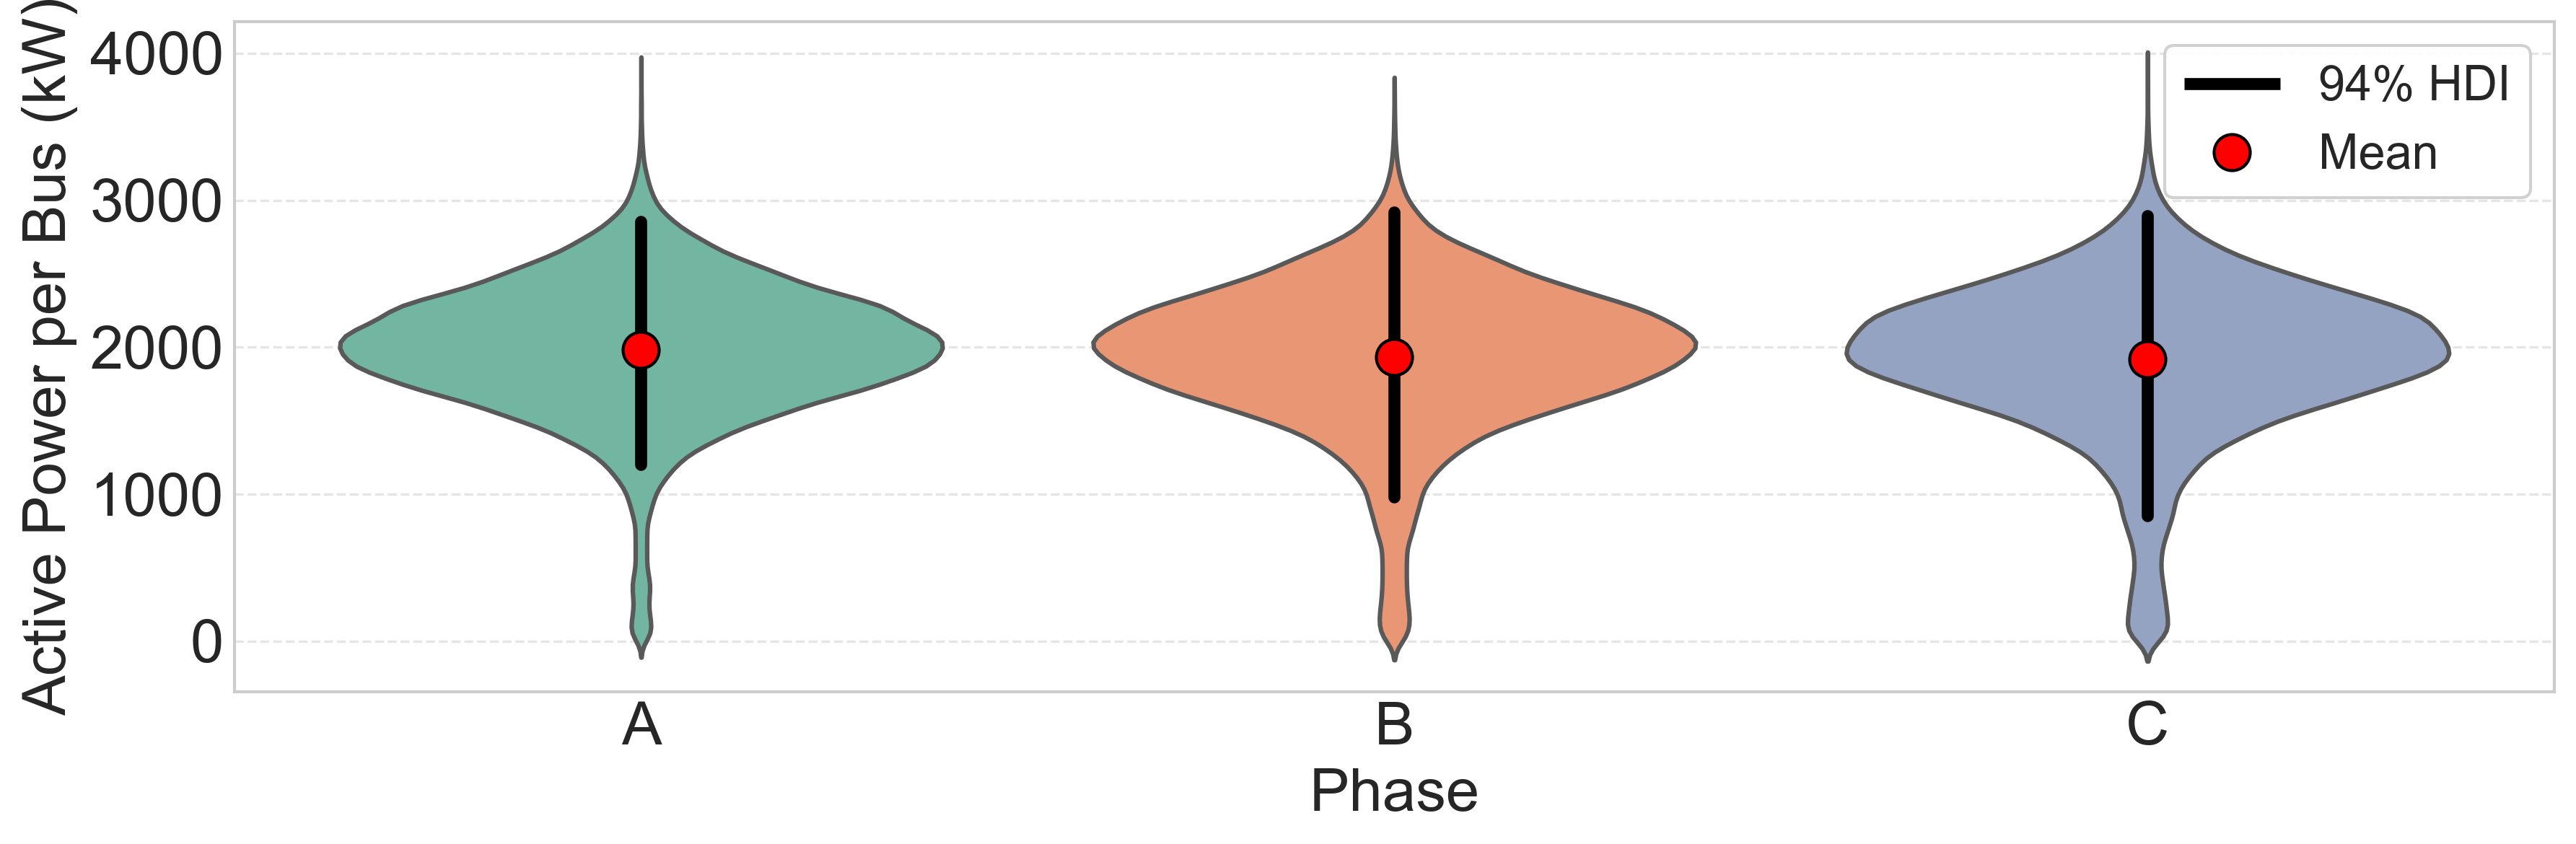

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# --- 1. Prepare Data: Filter Non-Zero Power for Each Phase ---
# We need to create a "long-form" DataFrame for Seaborn
# We only keep values > 0 to represent actual connected loads

# Filter Phase A
power_a = df_power.loc[df_power['P_A'] > 1e-3, 'P_A'].values
df_a = pd.DataFrame({'Power': power_a, 'Phase': 'A'})

# Filter Phase B
power_b = df_power.loc[df_power['P_B'] > 1e-3, 'P_B'].values
df_b = pd.DataFrame({'Power': power_b, 'Phase': 'B'})

# Filter Phase C
power_c = df_power.loc[df_power['P_C'] > 1e-3, 'P_C'].values
df_c = pd.DataFrame({'Power': power_c, 'Phase': 'C'})

# Combine into one DataFrame for plotting
plot_df = pd.concat([df_a, df_b, df_c], ignore_index=True)

# --- 2. Calculate Statistics (Mean & HDI) ---
stats_results = {}
for phase_char, dataset in zip(['A', 'B', 'C'], [power_a, power_b, power_c]):
    mean_val = np.mean(dataset)
    hdi_val = az.hdi(dataset, hdi_prob=0.94)
    stats_results[phase_char] = {'mean': mean_val, 'hdi': hdi_val}

print("--- Distribution Statistics (Individual Bus Loads) ---")
for phase, res in stats_results.items():
    print(f"Phase {phase}: Mean={res['mean']:.2f} kW, 94% HDI={res['hdi']}")

# --- 3. Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 4),dpi=300)

# Create the Violin Plot
# inner=None removes the default boxplot inside so we can draw our own stats
ax = sns.violinplot(x='Phase', y='Power', data=plot_df, palette="Set2", inner=None, linewidth=1.5)

# Overlay Mean and HDI
for i, phase in enumerate(['A', 'B', 'C']):
    stats = stats_results[phase]
    mean = stats['mean']
    hdi_low, hdi_high = stats['hdi']
    
    # Plot 94% HDI as a thick vertical line
    plt.vlines(i, hdi_low, hdi_high, colors='black', lw=4, zorder=5,
               label='94% HDI' if i == 0 else "")
    
    # Plot Mean as a red dot
    plt.plot(i, mean, 'o', color='red', markersize=12, markeredgecolor='black', zorder=6,
             label='Mean' if i == 0 else "")

# Formatting for Publication
plt.ylabel('Active Power per Bus (kW)', fontsize=20)
plt.xlabel('Phase', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add Legend
plt.legend(fontsize=16, loc='upper right', frameon=True, framealpha=0.9)

# Clean up grid
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()

plt.show()

## 4.2: Phase Allocation



--- Phase Allocation Statistics (Across Samples) ---
Phase A: Mean=39.93%, 94% HDI=[0.00%, 98.32%]
Phase B: Mean=29.64%, 94% HDI=[0.00%, 86.96%]
Phase C: Mean=26.46%, 94% HDI=[0.00%, 79.92%]
Phase AB: Mean=0.82%, 94% HDI=[0.00%, 3.89%]
Phase BC: Mean=2.37%, 94% HDI=[0.00%, 10.83%]
Phase AC: Mean=0.65%, 94% HDI=[0.00%, 4.42%]
Phase ABC: Mean=0.12%, 94% HDI=[0.11%, 0.21%]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


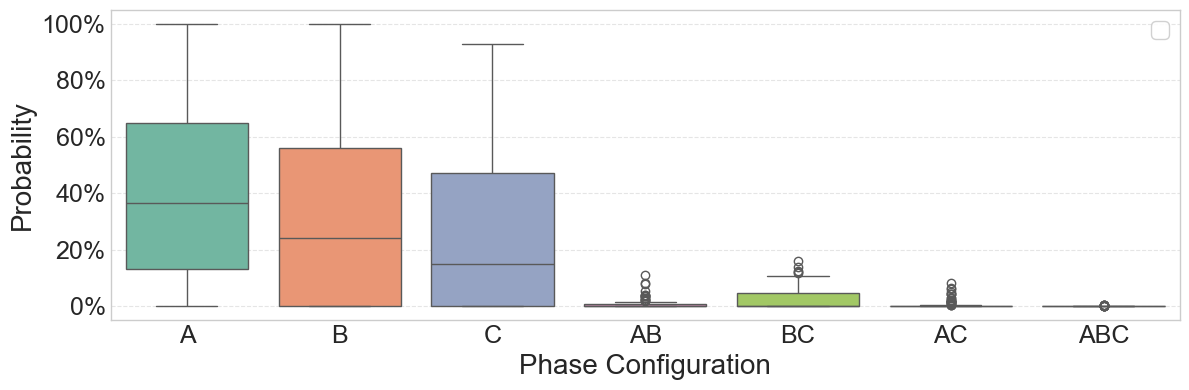

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# --- 1. Prepare Data: Calculate Phase Probabilities per Sample ---
# Group by sample_id and phase, then count the occurrences
phase_counts = df_power.groupby(['sample_id', 'phase']).size().unstack(fill_value=0)

# Normalize by the total number of buses per sample to get probabilities (0.0 to 1.0)
phase_probs = phase_counts.div(phase_counts.sum(axis=1), axis=0)

# Define the specific order for the x-axis
phase_order = ['A', 'B', 'C', 'AB', 'BC', 'AC', 'ABC']

# Ensure all columns exist (fill with 0 if a phase never appeared)
for p in phase_order:
    if p not in phase_probs.columns:
        phase_probs[p] = 0.0

# Melt the DataFrame to "long form" for Seaborn
plot_df = phase_probs[phase_order].melt(var_name='Phase', value_name='Probability')

# --- 2. Calculate Statistics (Mean & HDI) ---
stats_results = {}
for phase in phase_order:
    dataset = phase_probs[phase].values
    mean_val = np.mean(dataset)
    # 94% HDI is standard in Bayesian analysis (ArviZ default)
    hdi_val = az.hdi(dataset, hdi_prob=0.94)
    stats_results[phase] = {'mean': mean_val, 'hdi': hdi_val}

print("--- Phase Allocation Statistics (Across Samples) ---")
for phase in phase_order:
    res = stats_results[phase]
    print(f"Phase {phase}: Mean={res['mean']:.2%}, 94% HDI=[{res['hdi'][0]:.2%}, {res['hdi'][1]:.2%}]")

# --- 3. Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 4))

# Create the Violin Plot
# scale='width' ensures violins are visible even if the distribution is very tight
ax = sns.boxplot(
    x='Phase', 
    y='Probability', 
    data=plot_df, 
    palette="Set2", 
)



# Formatting for Publication
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Phase Configuration', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Format y-axis as percentage
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Add Legend
plt.legend(fontsize=16, loc='upper right', frameon=True, framealpha=0.9)

# Clean up grid
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()

plt.show()

## 4.3: Reliability functions (failure duration and frequency)

CAIDI Mean: 4.74 hours
CAIDI 94% HDI: [2.56001427e-03 1.19609570e+01]


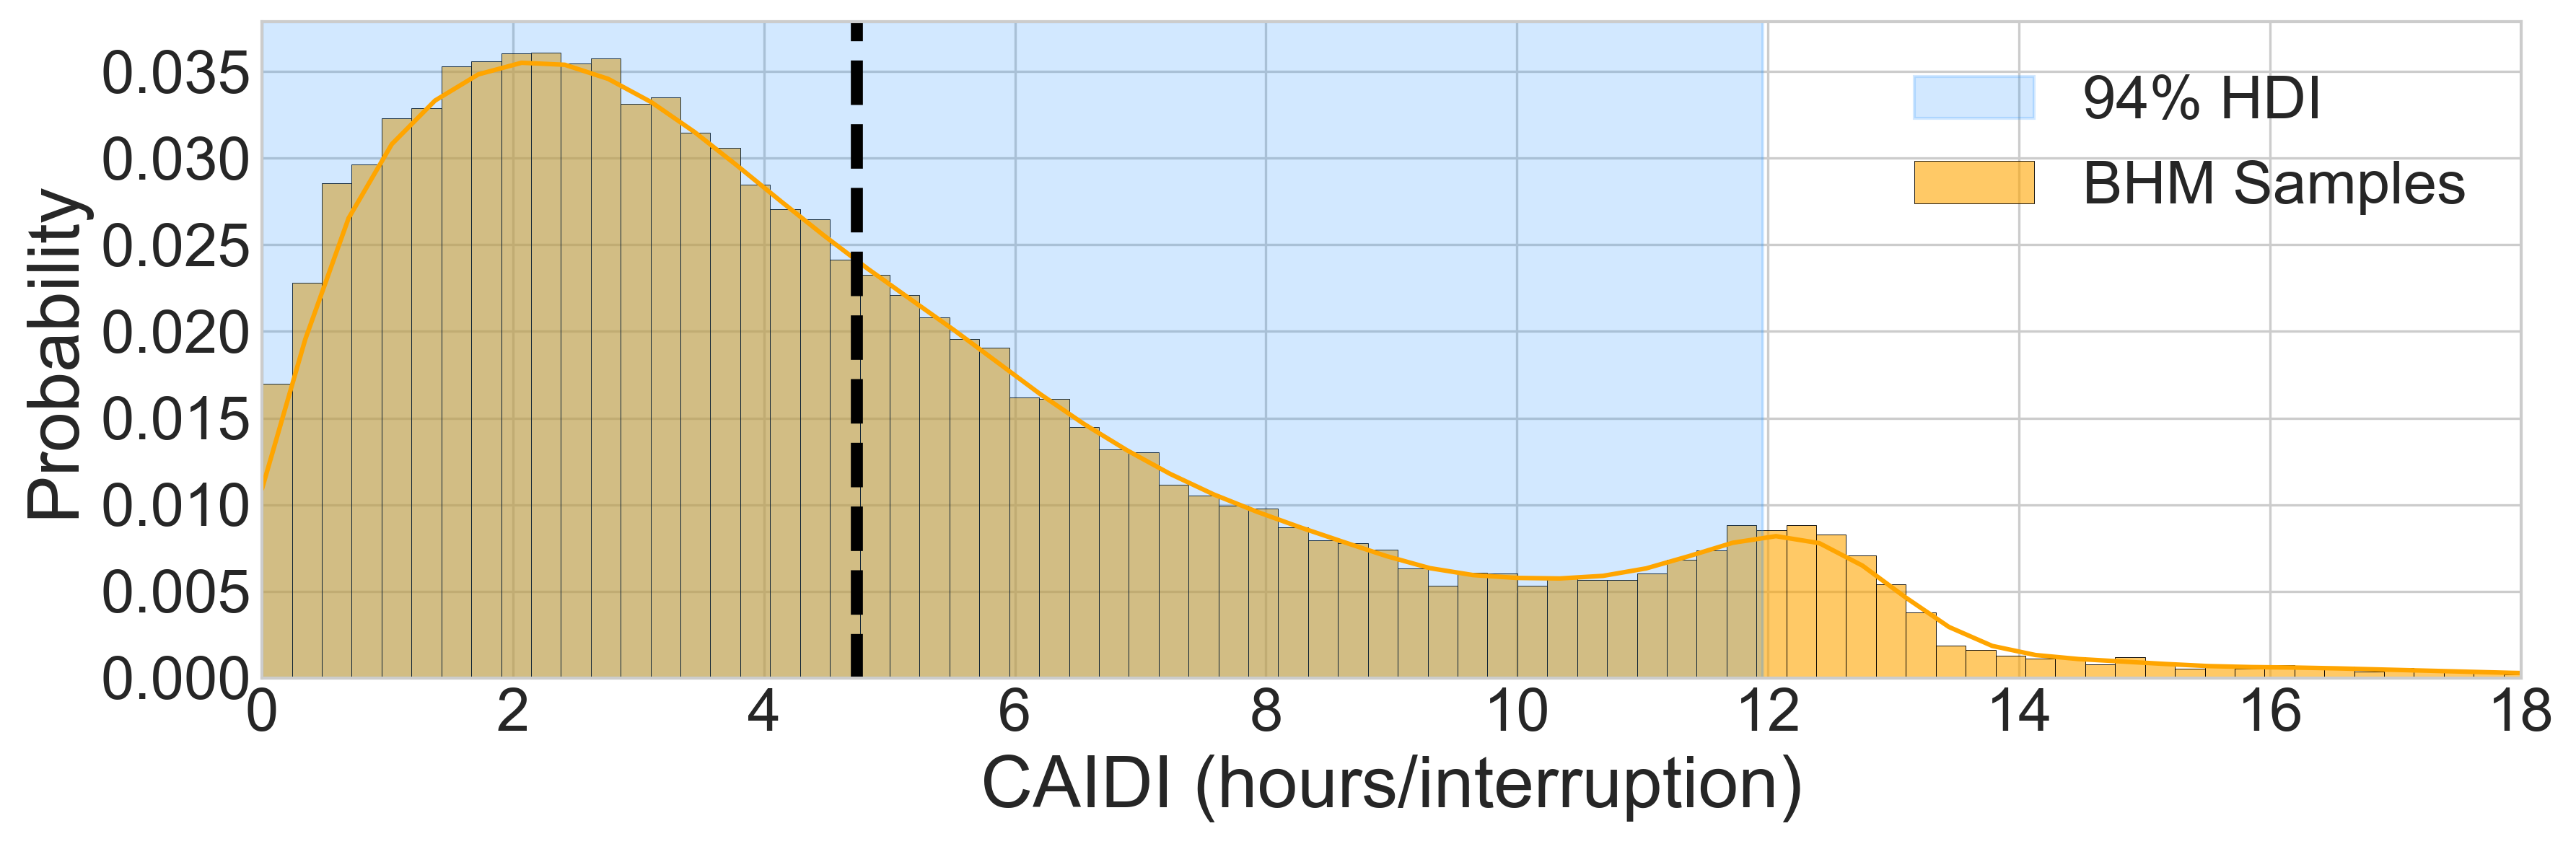

In [14]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Prepare Data for CAIDI ---
caidi_data = df_dur[df_dur.CAIDI_DIC!=0]['CAIDI_DIC'].values

# Calculate Statistics
mean_caidi = caidi_data.mean()
hdi_caidi = az.hdi(caidi_data, hdi_prob=0.94)

print(f"CAIDI Mean: {mean_caidi:.2f} hours")
print(f"CAIDI 94% HDI: {hdi_caidi}")

# --- 2. Visualize CAIDI ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 4),dpi=300)

# Plot the distribution
sns.histplot(caidi_data, kde=True, label='BHM Samples', stat='probability', color='orange', alpha=0.6)

# Plot Mean
plt.axvline(mean_caidi, color='k', linestyle='--', lw=4)

# Plot HDI
plt.axvspan(hdi_caidi[0], hdi_caidi[1], color='dodgerblue', alpha=0.2, label='94% HDI')

# --- 3. Finalize Plot ---
plt.xlabel('CAIDI (hours/interruption)', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,18) # Duration cannot be negative
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

CAIFI Mean: 1.16 interruptions/year
CAIFI 94% HDI: [0 4]


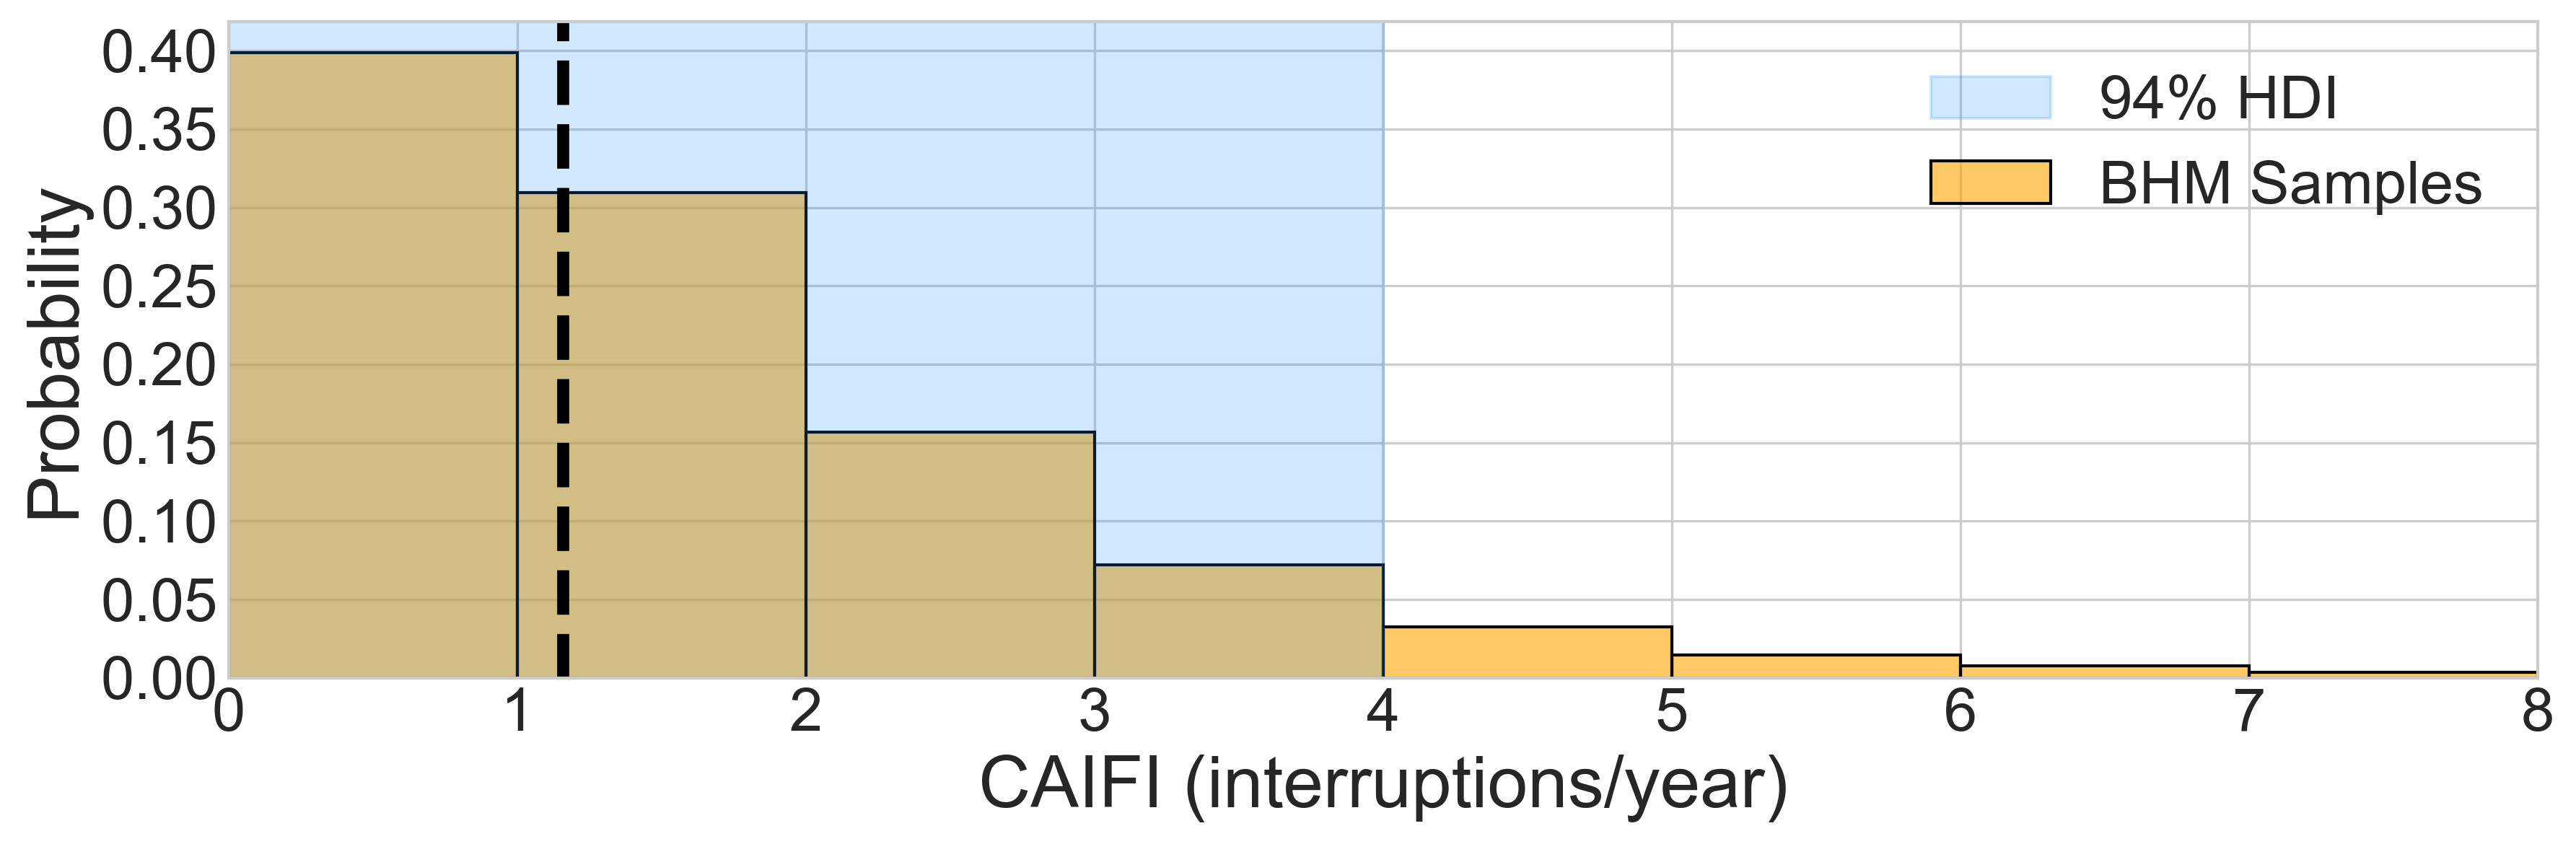

In [15]:
# --- 1. Prepare Data for CAIFI ---
caifi_data = df_freq['CAIFI_FIC'].values

# Calculate Statistics
mean_caifi = caifi_data.mean()
hdi_caifi = az.hdi(caifi_data, hdi_prob=0.94)

print(f"CAIFI Mean: {mean_caifi:.2f} interruptions/year")
print(f"CAIFI 94% HDI: {hdi_caifi}")

# --- 2. Visualize CAIFI ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 4),dpi=300)

# Plot the distribution
# discrete=True makes the bars align with integer values, which is good for frequency counts
sns.histplot(caifi_data, kde=False, label='BHM Samples', stat='probability', color='orange', alpha=0.6, binwidth=1)

# Plot Mean
plt.axvline(mean_caifi, color='k', linestyle='--', lw=4)

# Plot HDI
plt.axvspan(hdi_caifi[0], hdi_caifi[1], color='dodgerblue', alpha=0.2, label='94% HDI')

# --- 3. Finalize Plot ---
plt.xlabel('CAIFI (interruptions/year)', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,8) # Frequency cannot be negative
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

## 4.4) Line parameters (per-kilometer impedance and reactance)

In [4]:
df_imp

,sample_id,line_id,R1_ohm_per_km,X1_ohm_per_km
0,0,0,0.190962,0.149072
1,0,1,0.427131,0.459721
2,0,2,0.617716,0.423308
3,0,3,0.201254,0.245248
4,0,4,0.566278,0.131811
...,...,...,...,...
94995,99,945,0.565571,0.293537
94996,99,946,0.312819,0.224897
94997,99,947,0.763699,0.360424
94998,99,948,0.681305,0.417890


R1 Mean: 0.6469 Ohm/km
R1 94% HDI: [0.10985854 1.12969193]


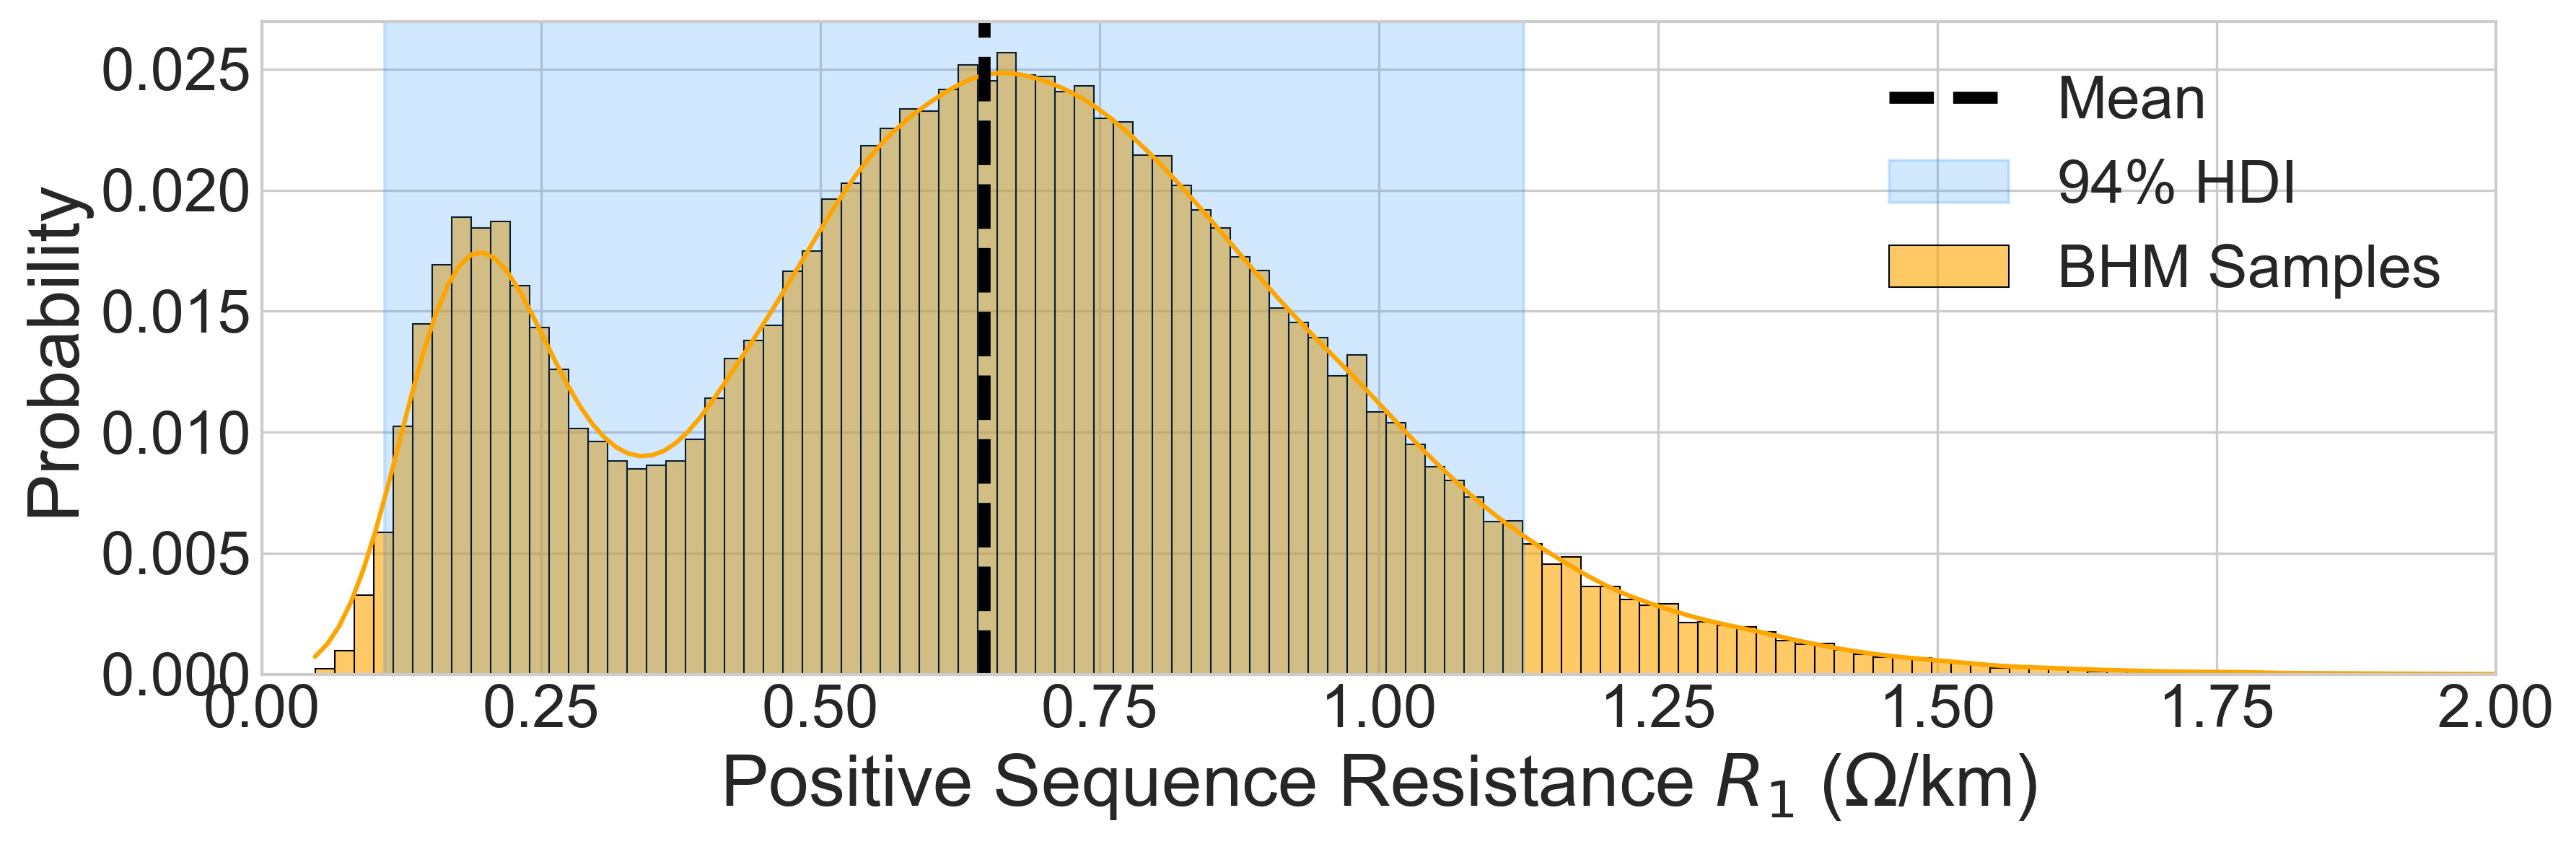

In [25]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Prepare Data for Resistance ---
r1_data = df_imp['R1_ohm_per_km'].values

# Calculate Statistics
mean_r1 = r1_data.mean()
hdi_r1 = az.hdi(r1_data, hdi_prob=0.94)

print(f"R1 Mean: {mean_r1:.4f} Ohm/km")
print(f"R1 94% HDI: {hdi_r1}")

# --- 2. Visualize Resistance ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 4), dpi=300)

# Plot the distribution
sns.histplot(r1_data, kde=True, label='BHM Samples', stat='probability', color='orange', alpha=0.6)

# Plot Mean
plt.axvline(mean_r1, color='k', linestyle='--', lw=4, label='Mean')

# Plot HDI
plt.axvspan(hdi_r1[0], hdi_r1[1], color='dodgerblue', alpha=0.2, label='94% HDI')

# --- 3. Finalize Plot ---
plt.xlabel(r'Positive Sequence Resistance $R_1$ ($\Omega$/km)', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((0,2))
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

X1 Mean: 0.2987 Ohm/km
X1 94% HDI: [0.0671942  0.56004783]


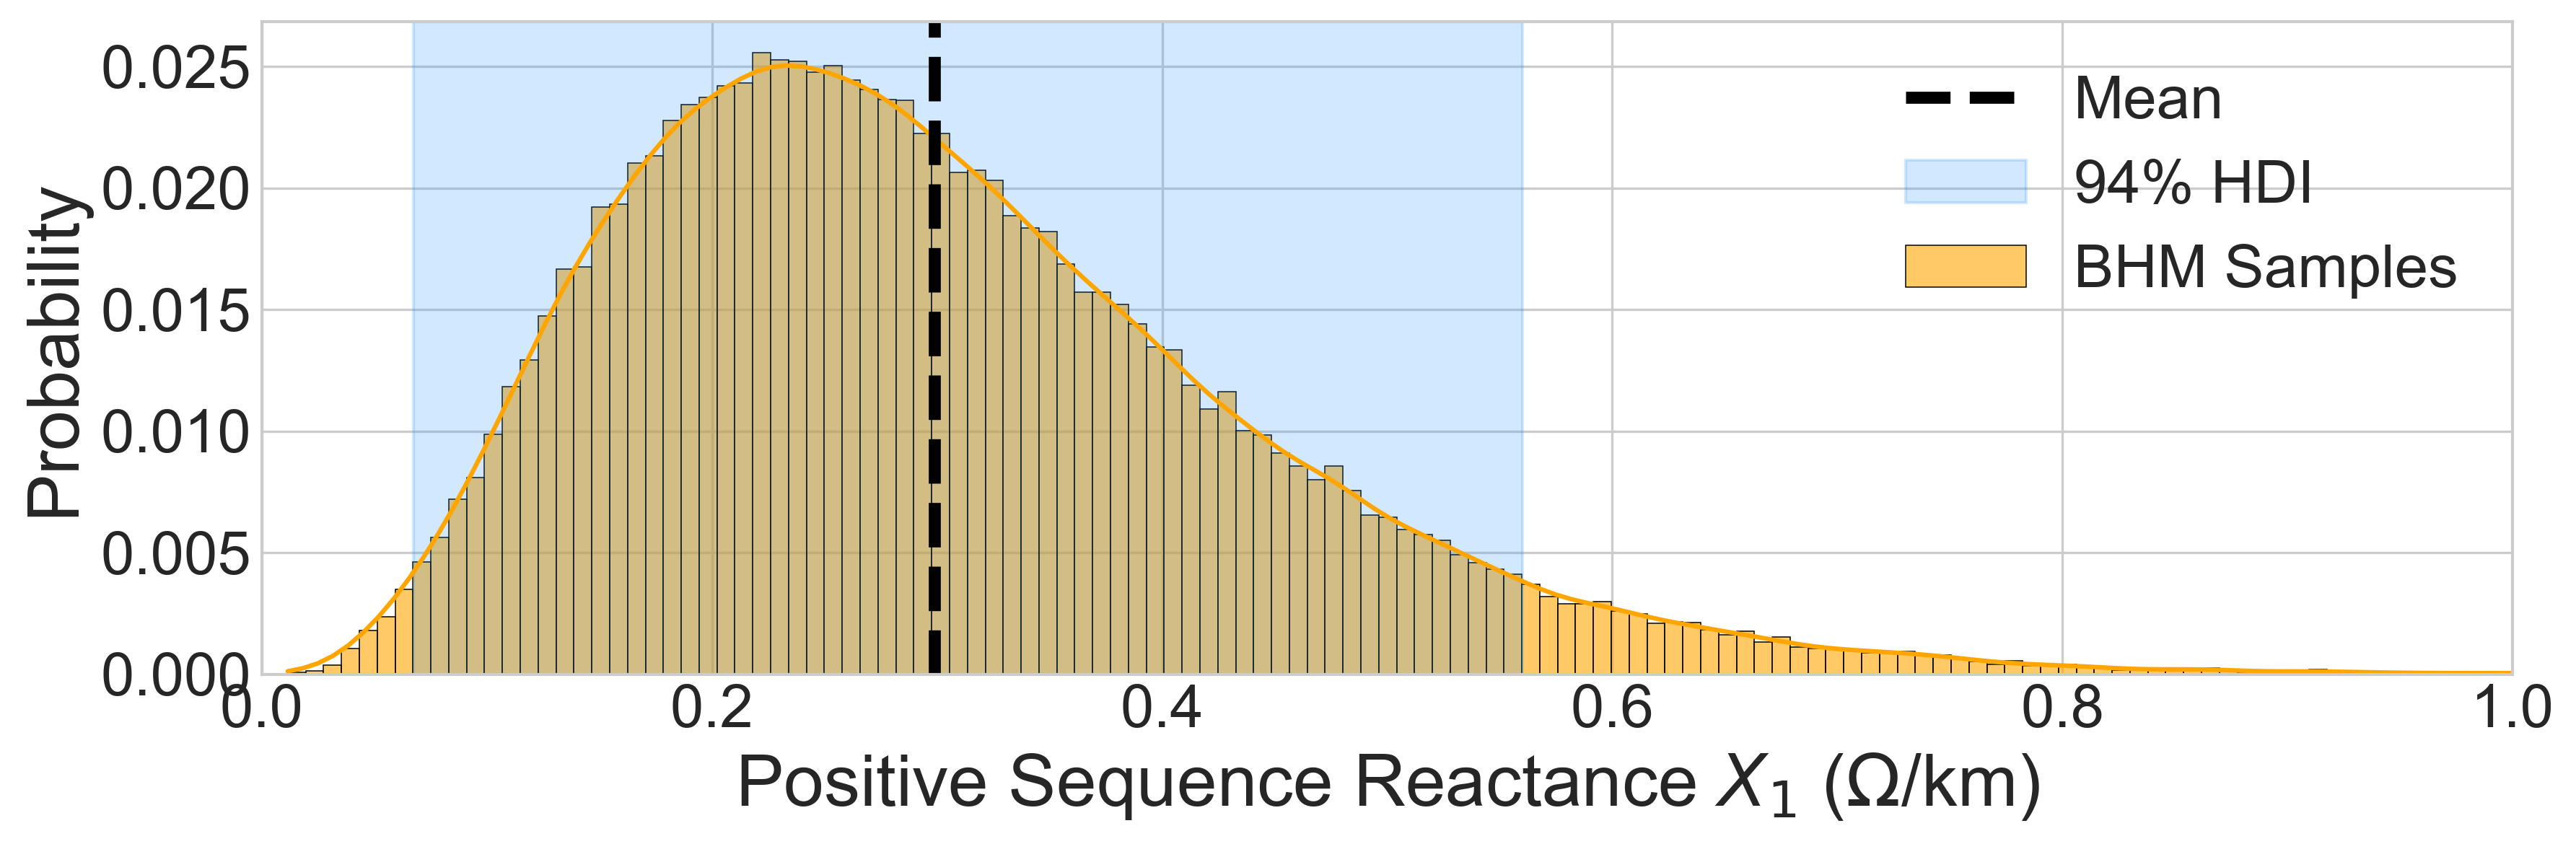

In [26]:
# --- 1. Prepare Data for Reactance ---
x1_data = df_imp['X1_ohm_per_km'].values

# Calculate Statistics
mean_x1 = x1_data.mean()
hdi_x1 = az.hdi(x1_data, hdi_prob=0.94)

print(f"X1 Mean: {mean_x1:.4f} Ohm/km")
print(f"X1 94% HDI: {hdi_x1}")

# --- 2. Visualize Reactance ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 4), dpi=300)

# Plot the distribution
sns.histplot(x1_data, kde=True, label='BHM Samples', stat='probability', color='orange', alpha=0.6)

# Plot Mean
plt.axvline(mean_x1, color='k', linestyle='--', lw=4, label='Mean')

# Plot HDI
plt.axvspan(hdi_x1[0], hdi_x1[1], color='dodgerblue', alpha=0.2, label='94% HDI')

# --- 3. Finalize Plot ---
plt.xlabel(r'Positive Sequence Reactance $X_1$ ($\Omega$/km)', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((0,1))
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()